# 6.6 Sourcing & Analyzing Time Series Data

### This script contains the following:

#### 1. Import libraries and data
#### 2. Subset, wrangle, and clean time-series data
#### 3. Time series analysis: decomposition
#### 4. Test for stationarity
#### 5. Stationarize the Data

### 1. Import libraries and data

In [119]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

# Disable deprecation warnings (suspended library or feature)
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [120]:
# Define path

path = r'C:\Users\Mark\_Electric Power Plant Emissions'

In [121]:
# Import the "emissions" data

df = pd.read_pickle(os.path.join(path, '03 Scripts', 'Prepared Data', 'emissions2015-2019-clean-el.pkl'))

In [122]:
# Import a list of distinct monthly dates

df2 = pd.read_csv(os.path.join(path, '03 Scripts', 'Original Data', 'monthly-emissions2015-2019.csv'), index_col = False)

In [123]:
df2.head()

,Year,Date
0,2015,2015-01-01
1,2015,2015-02-01
2,2015,2015-03-01
3,2015,2015-04-01
4,2015,2015-05-01


In [124]:
# Check the number of rows and columns, and also the date format

df2.shape

(60, 2)

### 2. Merge, summate, and subset the data

In [125]:
# The "Year" column is common in both data sets, and can be merged

df_merge_mnonthly = df.merge(df2, how = 'inner', on = 'Year', indicator = 'combined')

In [126]:
df_merge_mnonthly.head()

,Plant Code,Year,Plant Name,State,Sector Group,Sector Code,Prime Mover,Fuel Code,Aggregated Fuel Group,Generation (kWh),...,Fuel Units,Tons of CO2 Emissions,CO2 Emissions Metric Tonnes,NERC Region,Balancing Authority Code,Balancing Authority Name,EIA Balancing Authority Region,Emission Levels,Date,combined
0,3,2015,Barry,AL,Electric Power,1,CA,NG,GAS,2464536000,...,Mcf,46104.990709,41826.173191,unknown,unknown,unknown,unknown,low,2015-01-01,both
1,3,2015,Barry,AL,Electric Power,1,CA,NG,GAS,2464536000,...,Mcf,46104.990709,41826.173191,unknown,unknown,unknown,unknown,low,2015-02-01,both
2,3,2015,Barry,AL,Electric Power,1,CA,NG,GAS,2464536000,...,Mcf,46104.990709,41826.173191,unknown,unknown,unknown,unknown,low,2015-03-01,both
3,3,2015,Barry,AL,Electric Power,1,CA,NG,GAS,2464536000,...,Mcf,46104.990709,41826.173191,unknown,unknown,unknown,unknown,low,2015-04-01,both
4,3,2015,Barry,AL,Electric Power,1,CA,NG,GAS,2464536000,...,Mcf,46104.990709,41826.173191,unknown,unknown,unknown,unknown,low,2015-05-01,both


In [127]:
# Sum up all the values in the "combined" column to see whether there is a full match or not

df_merge_mnonthly['combined'].value_counts()

both          323832
left_only          0
right_only         0
Name: combined, dtype: int64

In [128]:
# Summation of the "Tons of CO2 Emissions" column by "Date"

df = df_merge_mnonthly.groupby(['Date']).agg({'Tons of CO2 Emissions':['sum']}).reset_index()

In [129]:
# Subset the columns of interest

df_subset = df[['Date', 'Tons of CO2 Emissions']]

In [130]:
# Check data types

df_subset.dtypes

Date                           object
Tons of CO2 Emissions  sum    float64
dtype: object

In [131]:
# Review the number of rows and columns

df_subset.shape

(60, 2)

In [132]:
# Review the dataframe

df_subset.head()

,Date,Tons of CO2 Emissions
,,sum
0,2015-01-01,2.239269e+09
1,2015-02-01,2.239269e+09
2,2015-03-01,2.239269e+09
3,2015-04-01,2.239269e+09
4,2015-05-01,2.239269e+09


In [133]:
# Check the data set type

type(df_subset)

pandas.core.frame.DataFrame

In [134]:
# Make the "Date" the index of the dataframe

df_subset = df_subset.set_index('Date') 

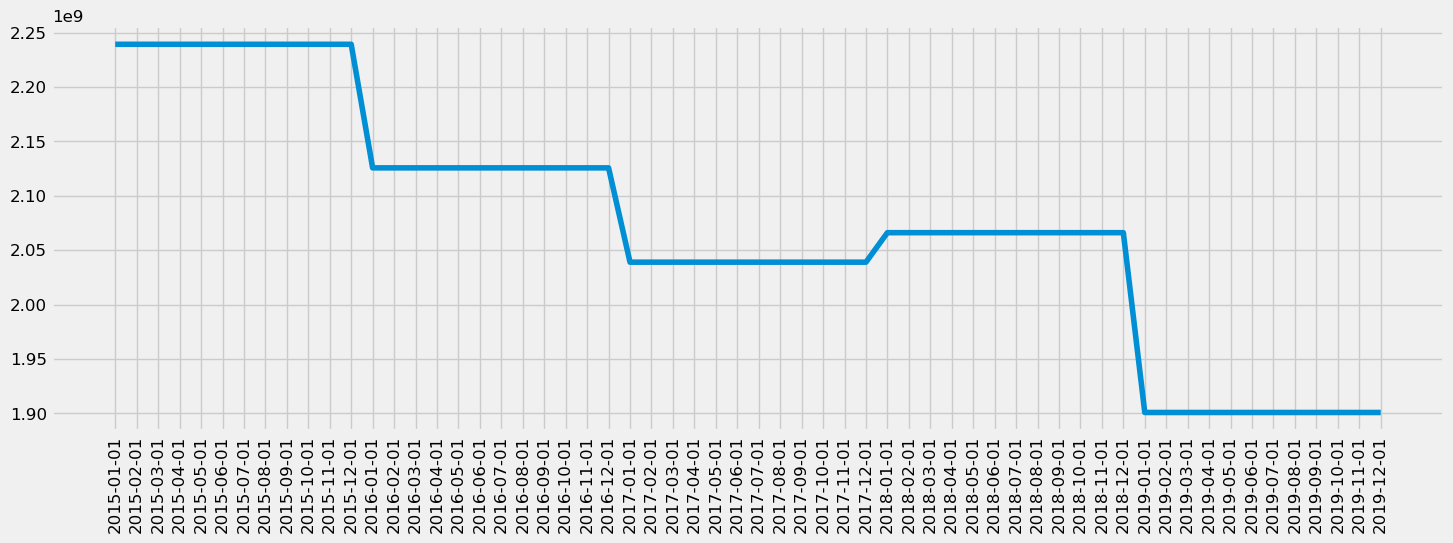

In [135]:
# Plot with matplotlib and set the dpi too 100 to avoid load time issues

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(16,5), dpi=100)
plt.xticks(rotation = 90)
plt.plot(df_subset)

The chart above is displaying as expected since the source of the data set, the EIA, has indicated that there are no monthly data and therefore the yearly values had to be split among the 12 months for each year.

### 3. Wrangle, and clean time-series data

In [136]:
# Reset index to use "Date" column as filter

df_subset = df_subset.reset_index()

In [137]:
# Set the range of date values to include for the "Date" column

df_subset = df_subset.loc[(df_subset['Date'] >= '2015-01-01') & (df_subset['Date'] < '2020-01-01')]

In [138]:
# Create a datetime column from "Date", set as index, and drop "Date" column

from datetime import datetime

df_subset['date'] = pd.to_datetime(df_subset['Date']) 
df_subset = df_subset.set_index('date')
df_subset.drop(['Date'], axis=1, inplace=True)
df_subset.head()

,Tons of CO2 Emissions
,sum
date,
2015-01-01,2.239269e+09
2015-02-01,2.239269e+09
2015-03-01,2.239269e+09
2015-04-01,2.239269e+09
2015-05-01,2.239269e+09


In [139]:
# Check for missing values

df_subset.isnull().sum() 

Tons of CO2 Emissions  sum    0
dtype: int64

In [140]:
# We know there will be duplicates due to how evenly the data was split over the months, 

dups = df_subset.duplicated()
dups.sum()

55

In [141]:
# In order to see the true nature of the data, 
# dropping the duplicates would be the best option

#df_subset = df_subset.drop_duplicates()

In [142]:
# Note that we are once again left with the 5 aggregated years

df_subset.shape

(60, 1)

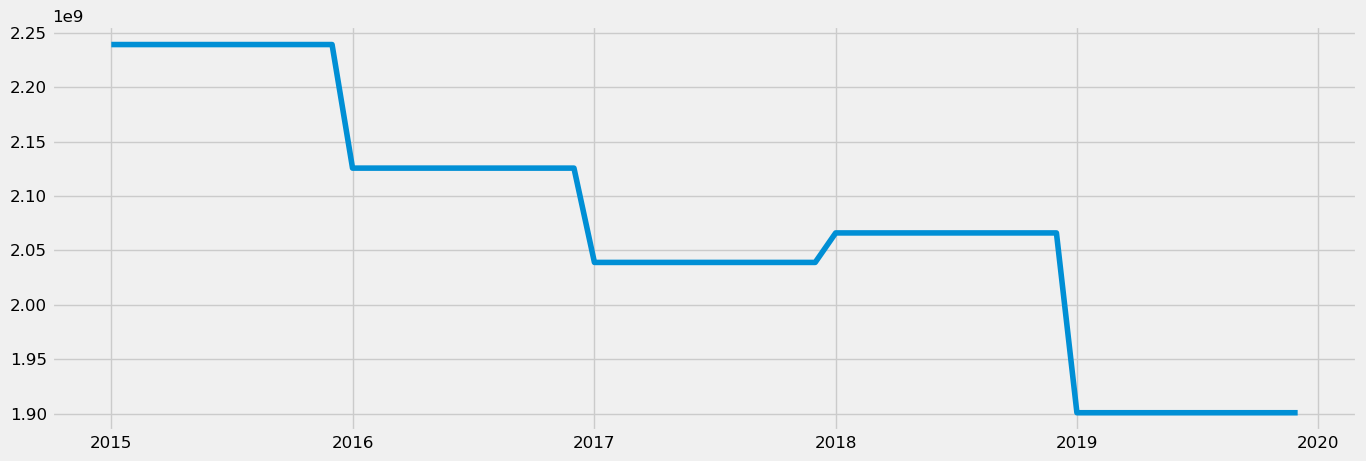

In [143]:
# Plot the data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_subset)

### 3. Time-series analysis: decomposition

In [144]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_subset, model='additive', freq=2)

In [145]:
# Define a fixed size for all charts

from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

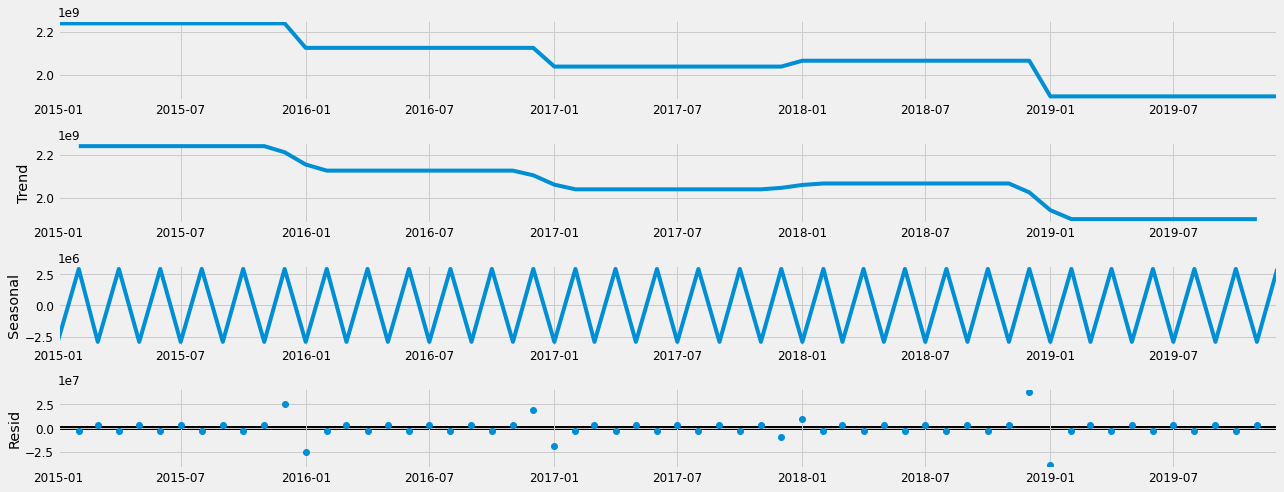

In [146]:
# Plot the separate components

decomposition.plot()
plt.show()

In the decomposed plot above we see that there is a clear downward trend in the data.

Seasonality is due to the aggregations occurring on a monthly basis. 

There is no noise (residual), except for the monthly and annual aggregations.

### 4. Test for stationarity

In [147]:
# To test, import model from statsmodels using the adfuller() function 
# Define a function that prints the returned array of numbers

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('The Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic',
                                         'p-value','Number of Lags Used',
                                         'Number of Observations Used'])
    for key, value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply test to time series
dickey_fuller(df_subset['Tons of CO2 Emissions'])

The Dickey-Fuller Stationarity test:
Test Statistic                 -0.917510
p-value                         0.782151
Number of Lags Used             0.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


With a significance level of 5 percent, the "Critical Value (5%)" has a value of -2.911939. This is much smaller than the test statistic, which is -0.917510, which means that you can accept the null hypothesis. So, "Dickey-Fuller Stationarity test" says that the data is not stationary.

With a p-value greater than 0.05, this result is not significant.

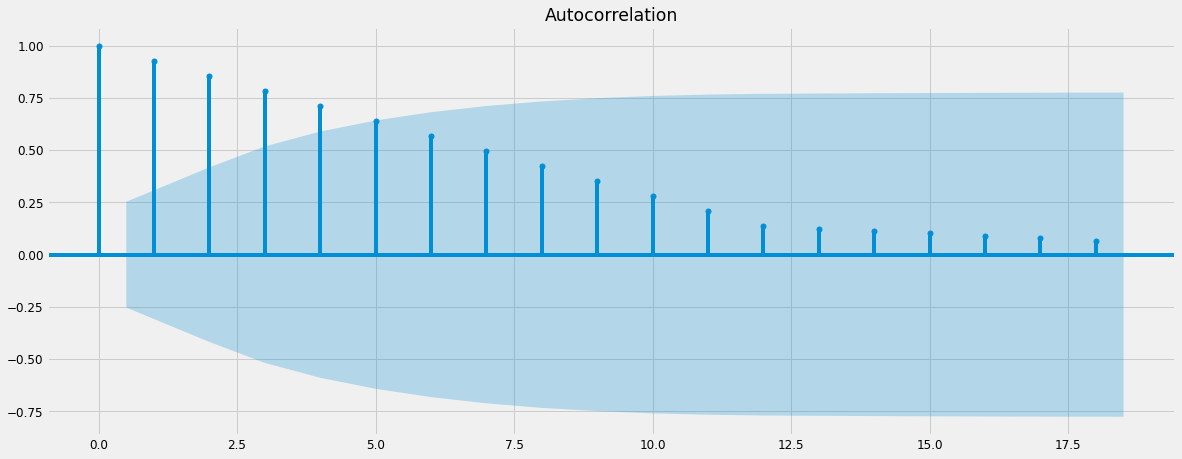

In [148]:
# Import autocorrelation and partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_subset)
plt.show()

In the autocorrelation and partial correlation plots above we see that most of the autocorrelation is clearly not significant except at zero and the 4 following points. This implies that the data is stationary.

### 5. Stationarize the Data

In [149]:
# Turn observation to t-1, making the whole thing t - (t -1)

data_diff = df_subset - df_subset.shift(1)

In [150]:
# Remove missing values as a result of the differencing, to run the Dickey-Fuller test

data_diff.dropna(inplace = True)

In [151]:
data_diff.head()

,Tons of CO2 Emissions
,sum
date,
2015-02-01,0.0
2015-03-01,0.0
2015-04-01,0.0
2015-05-01,0.0
2015-06-01,0.0


In [152]:
data_diff.columns

MultiIndex([('Tons of CO2 Emissions', 'sum')],
           )

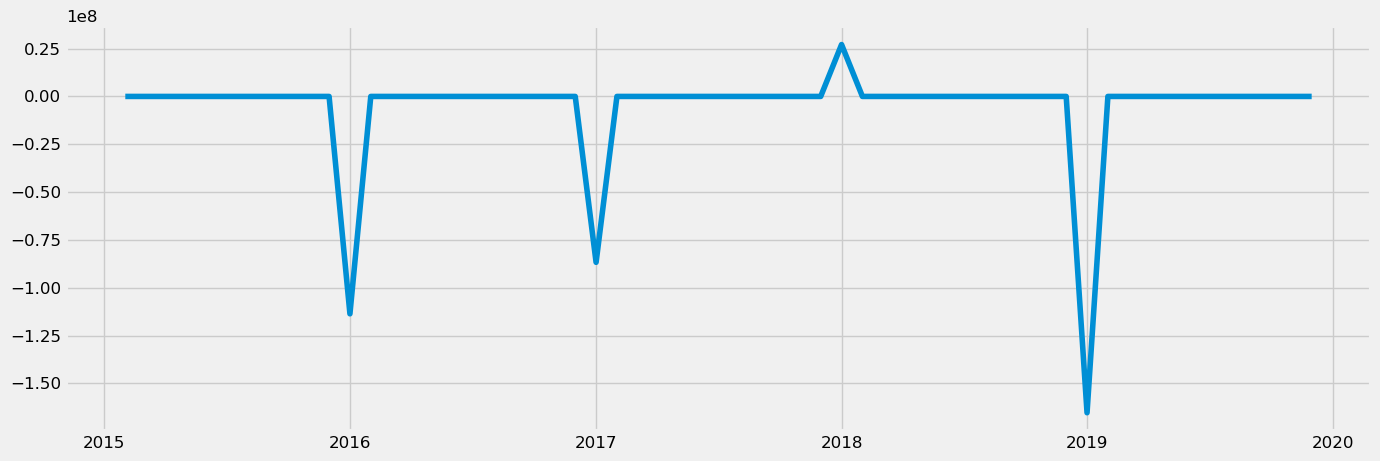

In [153]:
# Review what differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In the differencing chart above we see that the values on the y-axis have changed greatly. Stationarizing the data got rid of the trending downward slope.

In [154]:
# Perform the "The Dickey-Fuller Stationarity test"

dickey_fuller(data_diff) 

The Dickey-Fuller Stationarity test:
Test Statistic                -7.808227e+00
p-value                        7.185384e-12
Number of Lags Used            0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64


With a significance level of 5 percent, the "Critical Value (5%)" has a value of -2.912837e+00. This is much larger than the test statistic, which is -7.808227e+00, which means that you can reject the null hypothesis. 

The p-value is 7.185384e-12 (p < 0.05), so the result is significant.

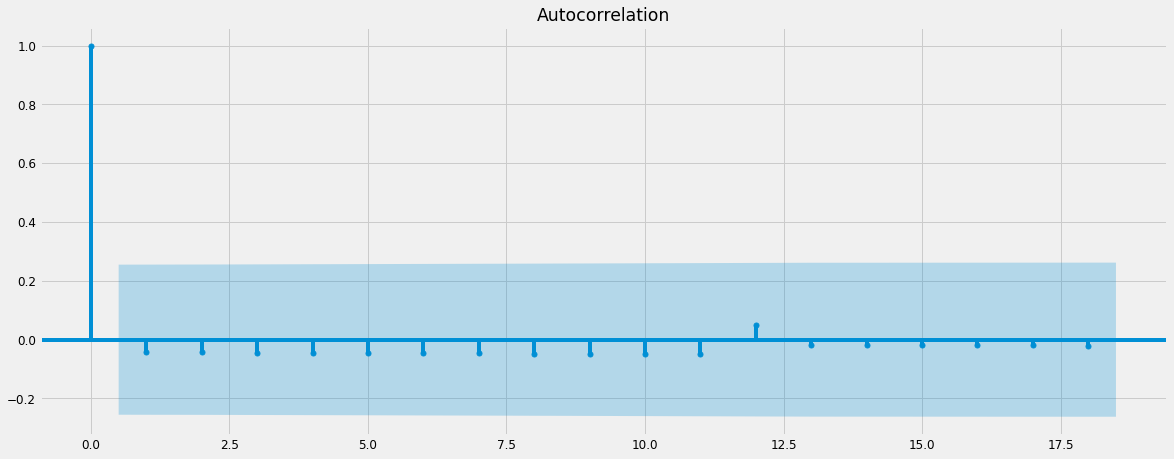

In [155]:
plot_acf(data_diff)
plt.show()

In the differencing chart above we see that the autocorrelation is clearly significant for zero but not significant for the rest of the data points.

So, stationarizing the data has made a difference and there are no lags that are significantly correlated with each other.